In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from scipy.spatial.distance import correlation

In [2]:
# Load the pre-trained VGG19 model + higher level layers
base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [3]:
def extract_face(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    
    if len(faces) == 0:
        return None
    
    x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
    face = img[y:y+h, x:x+w]
    return face

In [4]:
def extract_features(img_path, model):
    face = extract_face(img_path)
    if face is None:
        print(f"No face detected in image: {img_path}")
        return None
    
    face = cv2.resize(face, (224, 224))
    img_data = image.img_to_array(face)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    features = model.predict(img_data)
    return features.flatten()

In [5]:
def extract_background_features(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize for VGG19
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    # Extract features from a different layer (e.g., 'block5_conv3' for more general features)
    background_features = model.predict(img_data)
    return background_features.flatten()


In [6]:
def extract_combined_features(img_path, model, face_weight=0.7, background_weight=0.3):
    face_features = extract_features(img_path, model)
    background_features = extract_background_features(img_path, model)
    
    if face_features is None or background_features is None:
        return None
    
    # Combine features with weights
    combined_features = (face_weight * face_features) + (background_weight * background_features)
    return combined_features


In [7]:
def load_dataset_with_combined_features(dataset_path, model):
    combined_features = []
    image_paths = []
    labels = []
    for actor in os.listdir(dataset_path):
        actor_dir = os.path.join(dataset_path, actor)
        if os.path.isdir(actor_dir):
            for img_file in os.listdir(actor_dir):
                img_path = os.path.join(actor_dir, img_file)
                if img_path.endswith(('jpg', 'jpeg', 'png')):
                    embedding = extract_combined_features(img_path, model)
                    if embedding is not None:
                        combined_features.append(embedding)
                        labels.append(actor)
                        image_paths.append(img_path)
                    
    return np.array(combined_features), image_paths, labels


In [8]:
dataset_path = "D:\\Programming\\Project\\dataset_5"
# Load dataset and extract combined features
dataset_combined_features, dataset_image_paths, labels = load_dataset_with_combined_features(dataset_path, model)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
No face detected in image: D:\Programming\Project\dataset_5\abhay_deol\0d2583fb3e.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━

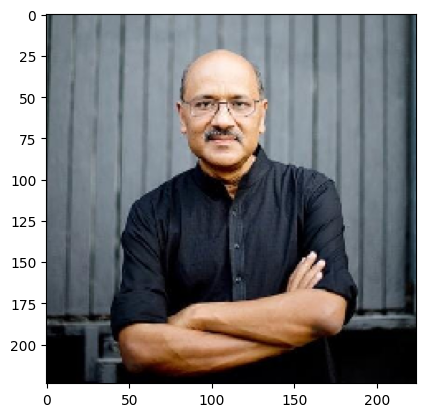

In [22]:
given_img_path = 'D:\\Programming\\Project\\Test image.jpg'
input_img = image.load_img(given_img_path, target_size=(224, 224))
input_img = image.img_to_array(input_img) / 255.0
plt.imshow(input_img)

In [23]:
# Cosine similarity (METHOD 1)
def find_similar_images_cosine_combined(given_img_path, combined_features, dataset_image_paths, model, top_n=5):
    given_img_features = extract_combined_features(given_img_path, model)
    if given_img_features is None:
        return [], []
    
    similarities = cosine_similarity([given_img_features], combined_features)[0]
    similar_indices = similarities.argsort()[-top_n:][::-1]
    top_similarities = similarities[similar_indices]
    top_similar_images = [dataset_image_paths[i] for i in similar_indices]
    
    return top_similar_images, top_similarities


# Find similar images using combined features
top_5_similar_images, top_5_similarities = find_similar_images_cosine_combined(given_img_path, dataset_combined_features, dataset_image_paths, model, top_n=5)

print("Top 5 similar images:")
for img_path, similarity in zip(top_5_similar_images, top_5_similarities):
    print(f"{img_path} - Similarity: {similarity * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Top 5 similar images:
D:\Programming\Project\dataset_5\anupam_kher\3e634f6d35.jpg - Similarity: 81.78%
D:\Programming\Project\dataset_5\anupam_kher\78c451e967.jpg - Similarity: 76.79%
D:\Programming\Project\dataset_5\saif_ali_khan\132927fc74.jpg - Similarity: 76.53%
D:\Programming\Project\dataset_5\saif_ali_khan\404af5634e.jpg - Similarity: 76.25%
D:\Programming\Project\dataset_5\rajkummar_rao\5a1d19b9b3.jpg - Similarity: 75.47%


Displaying image: D:\Programming\Project\dataset_5\anupam_kher\3e634f6d35.jpg
Displaying image: D:\Programming\Project\dataset_5\anupam_kher\78c451e967.jpg
Displaying image: D:\Programming\Project\dataset_5\saif_ali_khan\132927fc74.jpg
Displaying image: D:\Programming\Project\dataset_5\saif_ali_khan\404af5634e.jpg
Displaying image: D:\Programming\Project\dataset_5\rajkummar_rao\5a1d19b9b3.jpg


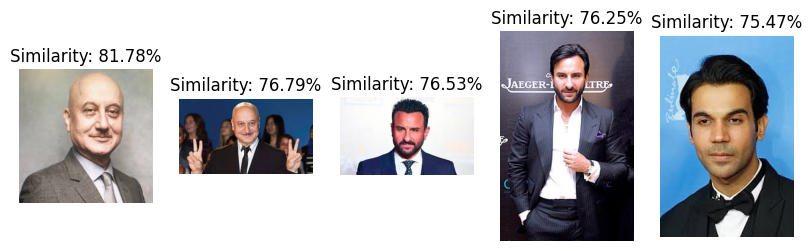

In [24]:
plt.figure(figsize=(10, 5))
idx = 0
for actor_image_path, similarity in zip(top_5_similar_images, top_5_similarities):
    print(f"Displaying image: {actor_image_path}")
    img = mpimg.imread(actor_image_path)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"Similarity: {similarity * 100:.2f}%")
    plt.axis('off')
    idx += 1
plt.show()